# New Section

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/drugsCom/preprocessing_1.csv")

In [ ]:
df=df[["review","label"]]

In [ ]:
df=df.dropna(axis=0, how='any')
df.reset_index(drop=True, inplace=True)

In [ ]:
X1=df['review']
Y1=df['label']
MAX_NB_WORDS = 30000

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_NB_WORDS)
X_tfidf = tfidf_vectorizer.fit_transform(X1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y1, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [100,120]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best max_depth
best_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_depth}")


Best max_depth: 120


In [ ]:
rf_model = RandomForestClassifier(n_estimators=120, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120, random_state=42)

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=42)
mlp_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(100, 100), random_state=42)

In [ ]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
# Generate predictions from each base model
mlp_pred = mlp_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

In [ ]:
# Combine predictions using stacking
stacked_predictions = np.column_stack((rf_pred, lr_pred,mlp_pred))

In [ ]:
import xgboost as xgb

In [ ]:
meta_model = xgb.XGBClassifier()
meta_model.fit(stacked_predictions, y_test)


# Make predictions using the meta-model
ensemble_pred = meta_model.predict(stacked_predictions)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy:", ensemble_accuracy)

# Calculate precision, recall, and F1 score
from sklearn import metrics
precision = metrics.precision_score(y_test, ensemble_pred, average='weighted')
recall = metrics.recall_score(y_test, ensemble_pred, average='weighted')
f1_score = metrics.f1_score(y_test, ensemble_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Ensemble Accuracy: 0.8991428615713688
Precision: 0.8998081227541387
Recall: 0.8991428615713688
F1 Score: 0.8941978525129802


# END

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


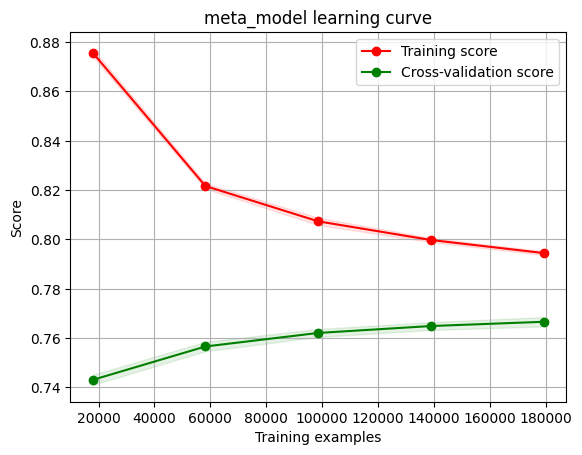

In [ ]:
plot_learning_curve(meta_model, "meta_model learning curve", X_tfidf, Y1, cv=6)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


# Plot the learning curve
fig, ax = plt.subplots(figsize=(10, 6))
common_params = {
    "X": stacked_predictions,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=20, test_size=0.25, random_state=0),
    "score_type": "accuracy",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
LearningCurveDisplay.from_estimator(meta_model, **common_params, ax=ax)
plt.show()
